Hi Team, 

I have tried to do the following tasks  : 
    
1. Created Database using the given excel sheet  - I used Oracle SQL developer 
2. Importing and reading it in Python Jupyter notebook  - I used CX_Oracle library in Python to connect to DB
3. Performed simple Data cleaning - Detect outliers and clean it. 
4. EDA - A couple of scatter plots, categorical plots and simple trial visuals towards the end of the notebook. 
5. Linear regression and its model summary ( Using Statsmodel and sklearn) 
6. Using Bokeh to create a user selected GUI (histogram of CL, VDSS, LOGD) 
7. Predict the value of CL based on Logd and VDSS values. 
8. Perform K means clustering to distinguish classes. ( Quite unrelatable, but could prove beneficial with more data such as patient / diagnosis) 

In [1]:
# Importing necessary libraries

import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import cx_Oracle
import sqlalchemy as sqla
import platform
import seaborn as sns
import scipy.stats as st


First, I will connect Oracle SQL to Python and the Following commands helps you to check it

In [2]:
print(sqla.__version__)
print(cx_Oracle.version)

1.3.19
8.0.1


In [3]:
lib_dir = r"C:\oracle_odbc\instantclient_19_10"

print("ARCH:", platform.architecture())
print("FILES AT lib_dir:")
for name in os.listdir(lib_dir):
    print(name)

ARCH: ('64bit', 'WindowsPE')
FILES AT lib_dir:
adrci.exe
adrci.sym
BASIC_LICENSE
BASIC_README
genezi.exe
genezi.sym
oci.dll
oci.sym
ocijdbc19.dll
ocijdbc19.sym
ociw32.dll
ociw32.sym
ojdbc8.jar
oramysql19.dll
oramysql19.sym
orannzsbb19.dll
orannzsbb19.sym
oraocci19.dll
oraocci19.sym
oraocci19d.dll
oraocci19d.sym
oraociei19.dll
oraociei19.sym
oraons.dll
orasql19.dll
orasql19.sym
ucp.jar
uidrvci.exe
uidrvci.sym
vc14
xstreams.jar


In [4]:
try:
    cx_Oracle.init_oracle_client(lib_dir=lib_dir)
except Exception as err:
    print("Error connecting: cx_Oracle.init_oracle_client()")
    print(err);
    sys.exit(1);

In [5]:
cx_Oracle.clientversion() 

(19, 10, 0, 0, 0)

In [6]:
platform.architecture()

('64bit', 'WindowsPE')

Using Python's CX_Oracle library, we are connecting to the SQL Database 

The basic details including DSN, User name and password can be obtained from the properties of DB connection

In [7]:
dsn_tns = cx_Oracle.makedsn('apollo.ite.gmu.edu', '1521', service_name='ite10g.ite.gmu.edu') 

In [8]:
conn = cx_Oracle.connect(
    user='jkrishn', 
    password='chongy', 
    dsn=dsn_tns
)

c = conn.cursor()


In [9]:
# Save the select query in a dataframe in order to perform the Data manipulation

query = """SELECT
            * 
           from 
           javelin_new
        """

In [10]:
data = pd.read_sql(query, con=conn)

Initially, we will perform EDA to understand the data and its structure

This helps us to get an idea of what functions can be necessarily applied to it before modelling or visualization


In [11]:
data.sample(5)

,DRUG_NAME,VDSS_VALUES,CL_VALUES,IONSTATE_VALUES,LOGD_VALUES
1077,93413-69-5,4.4,14,cationic,1.4
12,90402-40-7,6.3,14,cationic,1.2
192,79-43-6,0.19,5.3,anionic,-2.5
983,856866-72-3,0.91,1.19,neutral,2
237,548-73-2,1.41,8.92,cationic,0.54


In [12]:
print('Shape of the data is :', data.shape,'\n')

rows = len(data.axes[0])
cols = len(data.axes[1])

print("Number of Rows: " + str(rows))
print("Number of Columns: " + str(cols))

Shape of the data is : (1352, 5) 

Number of Rows: 1352
Number of Columns: 5


In [13]:
print('The column names in the data :\n',*data.columns, sep='\n')

The column names in the data :

DRUG_NAME
VDSS_VALUES
CL_VALUES
IONSTATE_VALUES
LOGD_VALUES


In [14]:
# Check for null values in each column
print("The number of NA values in each column :\n")
data.isnull().sum()

The number of NA values in each column :



DRUG_NAME           0
VDSS_VALUES        37
CL_VALUES           2
IONSTATE_VALUES     0
LOGD_VALUES         0
dtype: int64

Text(0, 0.5, 'Categories')

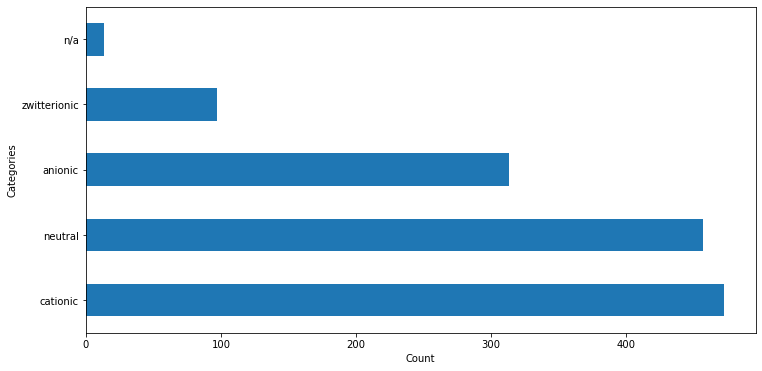

In [15]:
fig = plt.figure(figsize=(12, 6))

data['IONSTATE_VALUES'].value_counts().plot(kind = 'barh')
plt.xlabel('Count')
plt.ylabel('Categories')

In [16]:
# Find the data with Null/NA values
data[data.isnull().any(axis=1)].groupby(data['IONSTATE_VALUES']).count()

,DRUG_NAME,VDSS_VALUES,CL_VALUES,IONSTATE_VALUES,LOGD_VALUES
IONSTATE_VALUES,,,,,
anionic,7,0,7,7,7
cationic,19,1,18,19,19
neutral,11,1,10,11,11
zwitterionic,2,0,2,2,2


Since most of the Null values are either in cationic or neutral, we can afford to drop it without
affecting the structure of the data. 

Or we can choose to impute the data with mean value based on domain knowledge. 

For now, I will remove the rows with NA values. 


In [17]:
data.dropna(inplace = True)

In [18]:
# Get the bottom or top 10 values of CL to know the upper or lower boundaries.

data1 = data.sort_values('CL_VALUES',ascending = True).head(10)
print(data1)

        DRUG_NAME VDSS_VALUES CL_VALUES IONSTATE_VALUES LOGD_VALUES
423   112953-11-4        0.15    0.0037        cationic       -0.29
1196  154788-16-6        0.27    0.0047         neutral          -9
966      145-63-1        0.54    0.0057         neutral          -9
1150  163451-81-8        0.16     0.007         anionic         2.4
913   171500-79-1        0.14      0.01    zwitterionic        0.73
1094  879085-55-9        0.23      0.01         neutral         3.9
275   185955-34-4       0.048     0.013         anionic         1.7
1168     435-97-2         0.2      0.02         anionic         1.2
1324      83-46-5         0.3      0.02         neutral           9
369    37758-47-7        0.07      0.02         anionic          -4


In [19]:
# Converting the data in Integer/float values since they are numerical

data['VDSS_VALUES'] = data['VDSS_VALUES'].astype(float)
data['CL_VALUES'] = data['CL_VALUES'].astype(float)

<AxesSubplot:xlabel='VDSS_VALUES'>

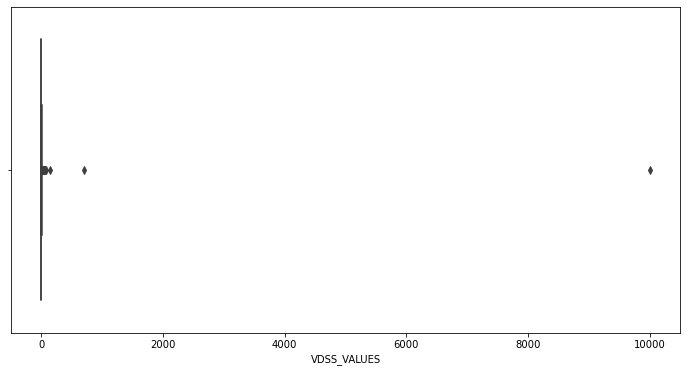

In [20]:
# Check and Remove outliers for VDss values

plt.rcParams["figure.figsize"] = (12,6)

sns.boxplot(data=data, x=data['VDSS_VALUES'])

In [21]:
# Removing the values above the upper whisker of the Box plot

Q1=data['VDSS_VALUES'].quantile(0.25)
Q3=data['VDSS_VALUES'].quantile(0.75)
IQR=Q3-Q1
print('Q1 : ', Q1)
print('Q3 : ', Q3)
print('IQR : ',IQR)
Lower_Whisker = (Q1 - 1.5)*IQR
Upper_Whisker = (Q3 + 1.5)*IQR
print('Lower_Whisker : ', Lower_Whisker)
print('Upper_Whisker : ', Upper_Whisker)

data = data[data['VDSS_VALUES'] < Upper_Whisker]

Q1 :  0.3
Q3 :  2.65
IQR :  2.35
Lower_Whisker :  -2.82
Upper_Whisker :  9.752500000000001


<AxesSubplot:xlabel='VDSS_VALUES'>

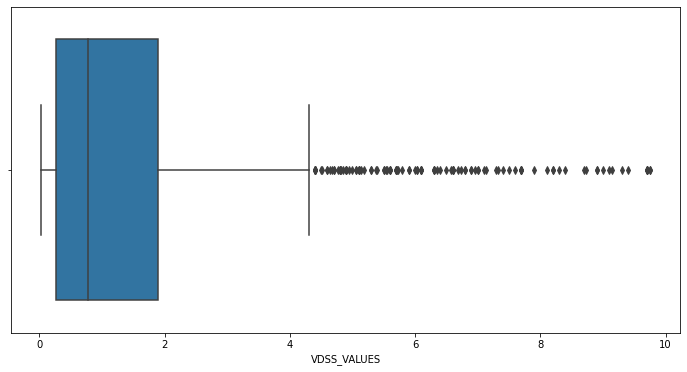

In [22]:
sns.boxplot(data=data, x=data['VDSS_VALUES'])

In [23]:
# If necessary, we can find the count of specific columns and their count, to see for outliers 

data.loc[data['CL_VALUES'] > 1000].count()

DRUG_NAME          2
VDSS_VALUES        2
CL_VALUES          2
IONSTATE_VALUES    2
LOGD_VALUES        2
dtype: int64

<AxesSubplot:xlabel='CL_VALUES'>

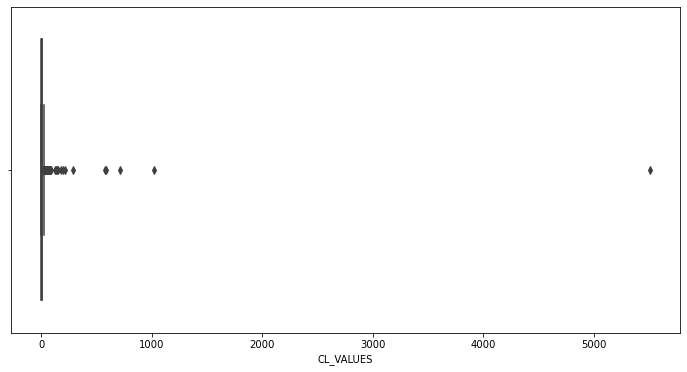

In [24]:
# Similarly, Removing outliers for CL values
sns.boxplot(data=data,x=data['CL_VALUES'])

In [25]:
Q1_cl=data['VDSS_VALUES'].quantile(0.25)
Q3_cl=data['VDSS_VALUES'].quantile(0.75)
IQR_cl=Q3_cl-Q1_cl
print('Q1 : ', Q1_cl)
print('Q3 : ', Q3_cl)
print('IQR : ',IQR_cl)
Lower_Whisker_cl = (Q1_cl - 1.5)*IQR_cl
Upper_Whisker_cl = (Q3_cl + 1.5)*IQR_cl
print('Lower_Whisker : ', Lower_Whisker_cl)
print('Upper_Whisker : ', Upper_Whisker_cl)


Q1 :  0.27
Q3 :  1.9
IQR :  1.63
Lower_Whisker :  -2.0048999999999997
Upper_Whisker :  5.542


In [26]:
data = data[data['CL_VALUES'] < Upper_Whisker_cl]

<AxesSubplot:xlabel='CL_VALUES'>

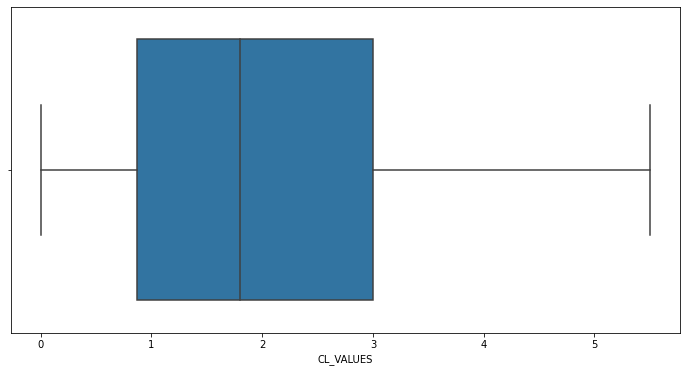

In [27]:
sns.boxplot(data=data,x=data['CL_VALUES'])

After trying to plot the LOGD values, I found that there are some rows with n/a values. Since they cannot be converted to integer while plotting, we can either impute them or 
choose to remove them. 

Being a bit short on the actual impact of imputation on the data, 
I will remove them as there is very less impact on the data. 


In [28]:
data.loc[data['LOGD_VALUES'] == 'n/a']

,DRUG_NAME,VDSS_VALUES,CL_VALUES,IONSTATE_VALUES,LOGD_VALUES
355,113662-23-0,0.21,1.60,n/a,n/a
356,770691-21-9,0.22,2.00,n/a,n/a
357,131410-48-5,0.20,1.79,n/a,n/a
358,742680-48-4,0.15,0.10,n/a,n/a
359,80529-93-7,0.27,1.94,n/a,n/a
360,120066-54-8,0.20,1.50,n/a,n/a
361,131069-91-5,0.16,1.20,n/a,n/a
362,770677-60-6,0.21,3.57,n/a,n/a
421,128446-35-5,0.21,1.80,n/a,n/a
628,1000120-98-8,0.10,0.67,n/a,n/a


In [29]:
data.drop(data.index[data['LOGD_VALUES'] == 'n/a'], inplace = True)

We can also check for Correlation to see if one variable influences the other. 

The below chart tells us that there is no extreme correlation between the variables. 

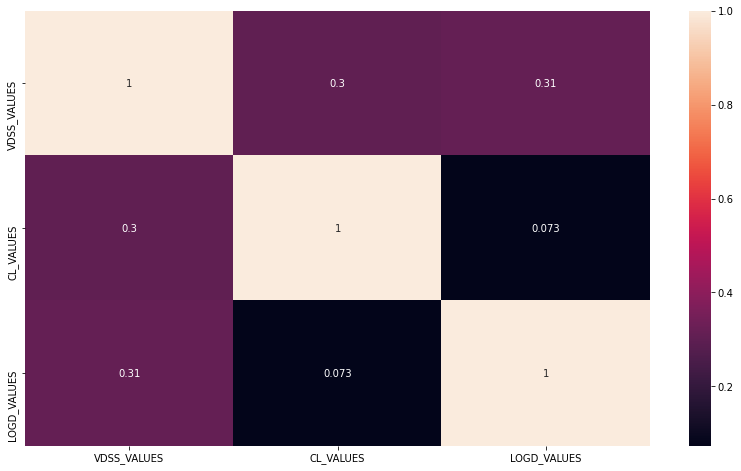

In [56]:
corrMatrix = data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

Our final data after cleaning looks like this. 

In [31]:
print('Shape of the data is :', data.shape,'\n')
print("Number of Rows: " + str(len(data.axes[0])))
print("Number of Columns: " + str(len(data.axes[1])))

Shape of the data is : (686, 5) 

Number of Rows: 686
Number of Columns: 5


Considering the original data and the cleaned version of it, almost half of the data is lost due to the noise present in it. 

After this, we can either choose to revert back to the previous steps to keep the data with NA or null values 
and do mean imputation if there is a need for more data points. Since sometimes, the originial context behind the data is 
lost if we keep on removing the rows with the null or na vlaues. 

We can simply use a for loop to fill the data with null values as the data's mean. 

For simplicity purposes, I will choose to keep this data as it is, in the previous step. 



Once we have the Preliminary/clean format of the data, we can proceed to visualization
and plot the values.

Note : We can still preprocess the data by checking if the data is biased or not. Since we are focusing on visualization, this is skipped. If we are trying to build a good model out of this data (shown towards the end), then little more preprocessing could be useful. 


Once we have the Preliminary clean format of the data, we can proceed to visualization



Now we can try out a simple scatter plot to understand the nature of distribution. 


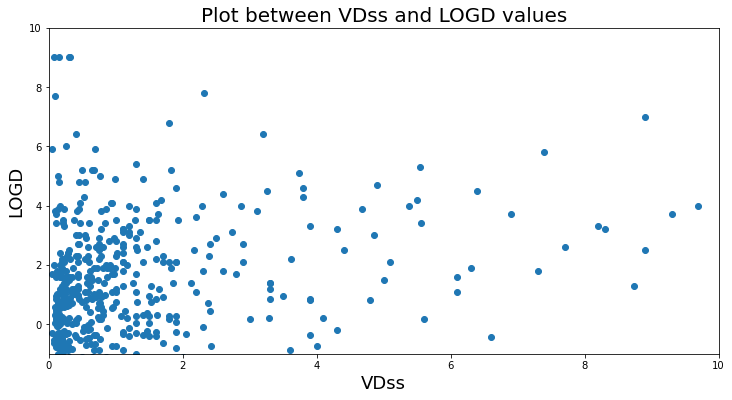

In [32]:
x = data['VDSS_VALUES'].apply(lambda x: float(x))
y = data['LOGD_VALUES'].apply(lambda x: float(x))

fig = plt.figure(figsize=(12, 6))


plt.scatter(x, y)

plt.xlim([0, 10])
plt.ylim([-1, 10])

plt.title("Plot between VDss and LOGD values",fontsize=20)
plt.xlabel("VDss",fontsize=18)
plt.ylabel("LOGD",fontsize=18)

plt.show()

Now we can try to fit the Regression line and see if we can predict the values correctly. 

We will use the Sklearn library. 

In [33]:
X = data['LOGD_VALUES'].values.reshape(-1,1)
y = data['CL_VALUES'].values.reshape(-1,1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, 
                                                    test_size = 0.3, random_state = 100)

regressor = LinearRegression()  
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
print("The actual and predicted values are : \n")
print(df)

plt.scatter(X_test, y_test,  color='gray')
print("\n\nThe below chart represents the line of equation that is fit after regressing the values : \n")
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()


NameError: name 'LinearRegression' is not defined

In [ ]:
plt.rcParams["figure.figsize"] = (14,8)

'''x_ticks = np.arange(0, 10)
plt.xticks(x_ticks)

y_ticks = np.arange(-1, 100, 5)
plt.yticks(y_ticks)'''

groups = data.groupby('IONSTATE_VALUES')

fig, ax = plt.subplots()

ax.margins(0.05) 

for name, group in groups:
    ax.plot(group['VDSS_VALUES'].apply(lambda x: float(x)), group['LOGD_VALUES'].apply(lambda x: float(x)), 
            marker='o', linestyle='', ms=8, label=name)
ax.legend()

y = data['LOGD_VALUES']

plt.xlim([-1, 12])
plt.yticks(np.arange(-5, 20, 5))

plt.title("Plot between VDss and logD values",fontsize=20)
plt.xlabel("VDSS_VALUES",fontsize=18)
plt.ylabel("LOGD_VALUES",fontsize=18)


plt.show()

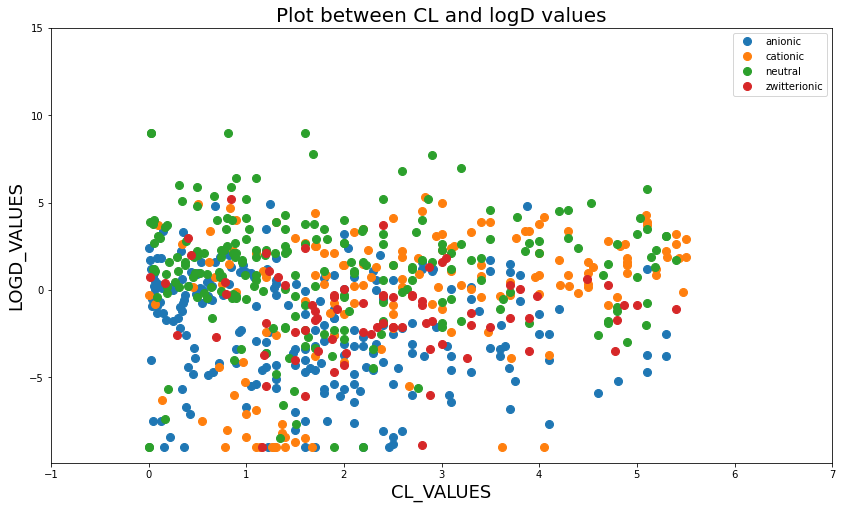

In [34]:
plt.rcParams["figure.figsize"] = (14,8)

groups = data.groupby('IONSTATE_VALUES')

fig, ax = plt.subplots()

ax.margins(0.05) 

for name, group in groups:
    ax.plot(group['CL_VALUES'].apply(lambda x: float(x)), group['LOGD_VALUES'].apply(lambda x: float(x)), 
            marker='o', linestyle='', ms=8, label=name)
ax.legend()

plt.xlim([-1, 7])
plt.yticks(np.arange(-5, 20, 5))

plt.title("Plot between CL and logD values",fontsize=20)
plt.xlabel("CL_VALUES",fontsize=18)
plt.ylabel("LOGD_VALUES",fontsize=18)

plt.show()

Now, for the GUI's, we can use many libraries according to its functionality. Since there is no specific requirement, 
I will use 'Bokeh', an interactive visualization chart, which is quite popular for modern web browsers. 
Also, compared to matplotlib, it provides great flexibility and charts in an appealing way. 

In [35]:
# Creating Interactive GUI using Bokeh

from bokeh.io import push_notebook, show, output_file, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.layouts import row, column, gridplot
from bokeh.models.widgets import Tabs, Panel
from bokeh.plotting import reset_output
from bokeh.transform import factor_cmap
from bokeh.models import HoverTool

In [36]:
output_file('filename.html')  # Render to static HTML, or 
output_notebook()  # Render inline in a Jupyter Notebook|

Loading BokehJS ...

In [37]:
index_cmap = factor_cmap('IONSTATE_VALUES', palette='Spectral8', 
                         factors=sorted(data.IONSTATE_VALUES.unique()))

In [38]:
figg = figure(title='VDss vs CL plot',
             plot_height=400, plot_width=700,
             x_axis_label='VDss', y_axis_label='Cl values',
             x_minor_ticks=2, y_range=(0, 5),
             )


figg.scatter('VDSS_VALUES', 'CL_VALUES',
             source = data,
             size=10,color='red',alpha=0.5,
             fill_color=index_cmap,
             legend_group = 'IONSTATE_VALUES')

            
figg.add_tools(HoverTool(tooltips=[('VDSS_VALUES', '@VDSS_VALUES'),
                                   ('CL_VALUES', '@CL_VALUES'),
                                  ('IONSTATE_VALUES', '@IONSTATE_VALUES')]))

show(figg)

The below Bokeh chart represents the Histogram representation of the data columns. 

We can customize according to the requirements / preferences. 

Here, the user can choose to view the histogram of the data fields as required. Other visuals can also 
be added instead of histogram. 

In [39]:
from bokeh.models.widgets import Panel
from bokeh.models.widgets import Tabs

In [40]:
p1 = figure(x_axis_label='Cl values', y_axis_label='Frequency')
p2 = figure(x_axis_label='VDSS values', y_axis_label='Frequency')
p3 = figure(x_axis_label='LOGD values', y_axis_label='Frequency')

# The logd values are being read as object and hence converting them into float values. 
data['LOGD_VALUES'] = np.array(data['LOGD_VALUES'], dtype=float)

hist, edges = np.histogram(data['CL_VALUES'], density=True, bins=50)
hist2, edges2 = np.histogram(data['VDSS_VALUES'], density=True, bins=50)
hist3, edges3 = np.histogram(data['LOGD_VALUES'], density=True, bins=50)


p1.quad(top=hist, bottom=0, 
       left=edges[:-1], right=edges[1:],
       line_color="white")
       
p2.quad(top=hist2, bottom=0, 
       left=edges2[:-1], right=edges2[1:],
       line_color="white")
       
p3.quad(top=hist3, bottom=0, 
       left=edges3[:-1], right=edges3[1:],
       line_color="white")

tab1 = Panel(child = p1, title='CL_VALUES')
 
tab2 = Panel(child = p2, title='VDSS_VALUES')
 
tab3 = Panel(child = p3, title='LOGD_VALUES')

In [41]:
layout = Tabs(tabs=[tab1, tab2, tab3],tabs_location='above')
print("\n Select the necessary column : \n")
output_file('tabs.html')
show(layout)


 Select the necessary column : 



Based on the VDss and LogD values, we can predict the CL values using a simple Regression model. 

There are many ways to build a regression model and fit the equation for the line. 

First, we will use the Sklearn's method. 

In [42]:
from sklearn import linear_model

In [43]:
X = data[['VDSS_VALUES','LOGD_VALUES']]
y = data['CL_VALUES']

regr = linear_model.LinearRegression()
regr.fit(X, y)

LinearRegression()

In [44]:
print('Intercept : ', regr.intercept_)
print('Coefficients : ', regr.coef_)

Intercept :  1.7466990205583126
Coefficients :  [ 0.30498972 -0.00959241]


Now since we fit the model, we can try to predict the CL value based on the VDSS and LogD observations

In [45]:
VDSS_VALUES = 0.75
LOGD_VALUES = 1.3

print ('\nPredicted CL value : ', regr.predict([[VDSS_VALUES ,LOGD_VALUES]]))


Predicted CL value :  [1.96297118]


We can also use Stastmodel library to fit the model and understand the Model summary.

It could give us a better understanding of the Model. 

In [46]:
import statsmodels.api as sm

In [47]:
X = sm.add_constant(X) # adding a constant

model = sm.OLS(y.astype(float), X.astype(float)).fit()
predictions = model.predict(X.astype(float))

In [48]:
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              CL_VALUES   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     34.36
Date:                Wed, 24 Mar 2021   Prob (F-statistic):           6.07e-15
Time:                        09:57:41   Log-Likelihood:                -1195.7
No. Observations:                 686   AIC:                             2397.
Df Residuals:                     683   BIC:                             2411.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.7467      0.068     25.847      

Note : The Co-efficients of the two Predictor variables shown by the Sklearn and statsmodels outputs are same.
This shows that the procedure followed is correct. 

As we can see from the Model summary, it is not a very good fit indeed. 

The values of R.sqr and Adj.R.Sqr are very low indicating that the regression model 
does not fit the data very well. Still, it gives us some insight into the data. 

Further steps to improve the model would be to see if we can filter the noise from the data
and tweak any other parameters or even use other ML models that can handle outliers such as Random Forest. 



Since we have cluster of data points, we can try to classiy them using K means clustering
to see if any business oriented questions can be answered such as what a specific cluster might represent. 

K means:

In [49]:
from sklearn.cluster import KMeans

In [50]:
X = data[['VDSS_VALUES','LOGD_VALUES']]

km = KMeans(n_clusters=3, n_init = 10, init = "random", random_state = 42)

km.fit(X)

y_kmeans = km.predict(X)

Text(0, 0.5, 'LOGD_VALUES')

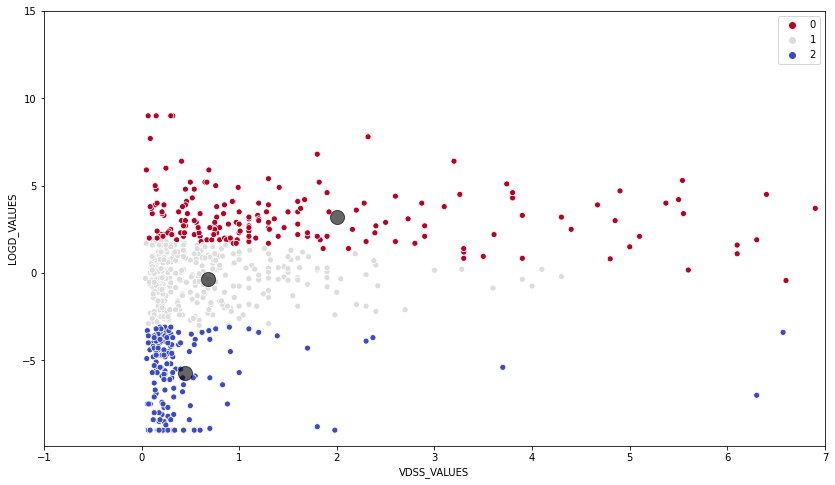

In [51]:
sns.scatterplot(data=data, x="VDSS_VALUES", y="LOGD_VALUES", hue= y_kmeans, palette = "coolwarm_r")
centers = km.cluster_centers_
# Plot centers
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha = 0.6)
plt.xlim([-1, 7])
plt.yticks(np.arange(-5, 20, 5))
plt.xlabel("VDSS_VALUES")
plt.ylabel("LOGD_VALUES")

We can see that we can define the number of clusters beforehand ( here I have set it to 3 ) and visualize the clusters. 

The clusters look neat and it does provide some food for thought in understanding the distribution of the data. When we have a patients information, it can used to predict distribution of certain classes.  

We can also refine the parameters of K means further to get a good classification. 
Also, given the values of VDss and LogD, we can predict to which class or cluster it belongs to. 

In [52]:
new_data = [[0.05, 2.8]]

y_pred = km.predict(new_data)
y_pred

array([0])

Note: 

The below charts are some of the initial versions and can be worked on for further appealing visuals. 

Here, I was just trying to see if anything can be mined out of these visuals. 

Kindly disregard them if they are not useful. 

C:\Users\murug\Anaconda3\lib\site-packages\seaborn\axisgrid.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


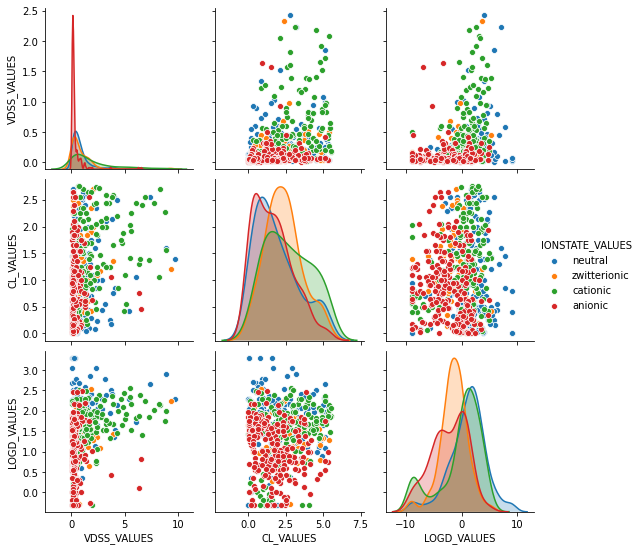

In [53]:
pp = sns.pairplot(data, hue="IONSTATE_VALUES")
pp.set(yticklabels=np.arange(-0.5, 25, 0.5))

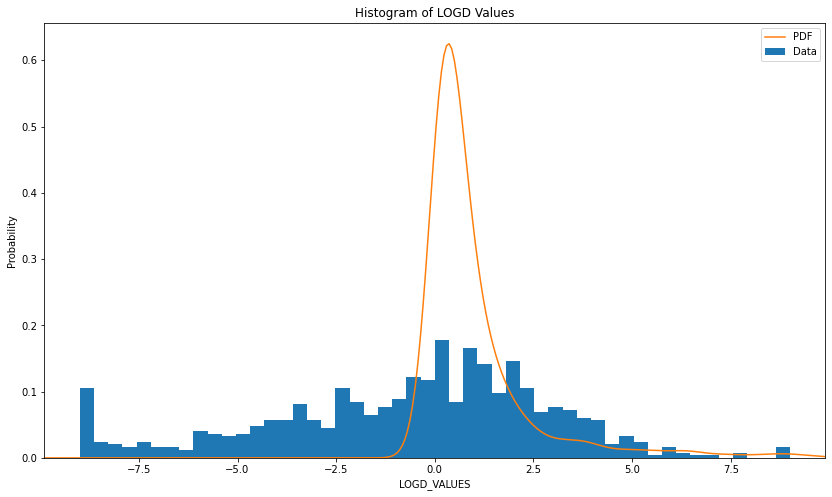

In [54]:
import scipy.stats as st

plt.hist(data['LOGD_VALUES'], density=True, bins=50, label="Data")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(x)
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper right")
plt.ylabel('Probability')
plt.xlabel('LOGD_VALUES')
plt.title("Histogram of LOGD Values");

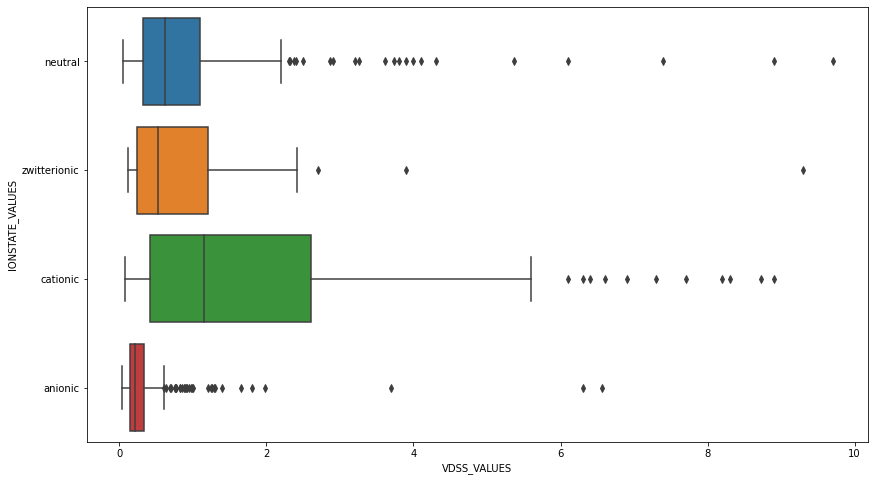

In [55]:
sns.boxplot( y=data["IONSTATE_VALUES"], x=data["VDSS_VALUES"].apply(lambda x: float(x)));
plt.show()